In [34]:
import community as community_louvain
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import time
import pandas as pd

In [5]:
def load_graph(graph_file):
    print(f"Loading graph from {graph_file}...")
    start_time = time.time()
    
    # Load the graph
    G = nx.read_graphml(graph_file)
    
    # Convert position strings back into lists of integers
    for node in G.nodes:
        pos_str = G.nodes[node].get('pos', '')  # Use .get to avoid KeyError if 'pos' does not exist
        if pos_str:  # Check if the position string is not empty
            G.nodes[node]['pos'] = list(map(int, pos_str.split(',')))
        else:
            G.nodes[node]['pos'] = []

    end_time = time.time()
    print(f"Graph loaded in {end_time - start_time:.2f} seconds. It has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
    return G

In [7]:
G = load_graph("spotify_AugWeek1.graphml")

Loading graph from spotify_AugWeek1.graphml...
Graph loaded in 4.30 seconds. It has 5420 nodes and 114579 edges.


# Louvain Method

This will partition our network based on modularity using the fast greedy algorithm, or more specifically, the Louvain Hirarchy Method

In [21]:
partition = community_louvain.best_partition(G)

# Add community membership as a node attribute
for node, community in partition.items():
    G.nodes[node]['community'] = community

    # Convert the list of positions to a string
    G.nodes[node]['pos'] = ','.join(map(str, G.nodes[node]['pos']))

In [22]:
# Export the graph to a GraphML file
output_path = "network_with_communities.graphml"
nx.write_graphml(G, output_path)

In [27]:
# Use this to visualize your dendogram
dendo = community_louvain.generate_dendrogram(G)

# Agglomoratative Clustering

In [24]:
def calculate_similarity_matrix(G):
    # Initialize an empty matrix with zeros
    n = len(G.nodes())
    similarity_matrix = np.zeros((n, n))
    
    # Iterate through all pairs of nodes
    for i, node_i in enumerate(G.nodes()):
        for j, node_j in enumerate(G.nodes()):
            if i != j:
                # Calculate J_N(i, j), the number of common neighbors
                common_neighbors = len(list(nx.common_neighbors(G, node_i, node_j)))
                
                # Calculate k_i and k_j, the degrees of node_i and node_j
                k_i = G.degree(node_i)
                k_j = G.degree(node_j)
                
                # Calculate the similarity score x_(i, j)
                similarity_matrix[i][j] = common_neighbors / min(k_i, k_j)
    
    return similarity_matrix

In [25]:
similarity_matrix = calculate_similarity_matrix(G)
similarity_matrix

array([[0., 1., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

KeyError: 0

# Convert to Table for Analysis

In [41]:
G.nodes(data=True)

NodeDataView({'spotify:track:7o9OVmPIE0oGbxP67WiT5r': {'artist_name': 'Al Green', 'track_name': "Truth N' Time", 'duration_ms': 222213, 'album_name': "Truth N' Time", 'pos': '0', 'community': 0}, 'spotify:track:6cB125fcIdCfgRnGm3KwtC': {'artist_name': 'Al Green', 'track_name': 'Have You Been Making Out OK', 'duration_ms': 225920, 'album_name': 'Call Me', 'pos': '1', 'community': 0}, 'spotify:track:2O6AOuCNdPbFPf1fx1piIo': {'artist_name': 'Al Green', 'track_name': "Hangin' On", 'duration_ms': 260826, 'album_name': 'Al Green Explores Your Mind', 'pos': '2', 'community': 0}, 'spotify:track:1BltsyC5W3SAABdxyrDXwi': {'artist_name': 'Disclosure', 'track_name': 'Latch', 'duration_ms': 255631, 'album_name': 'Settle', 'pos': '3,5,10,11,12,13,78,80,48,23,8,69,21,11,68,71,71,13,39,6,12,22,0,51,11,96,62,61,16,72,58,173,2,33,189,51,100,49,60,47,9,9,21,13,85,34,6,32,8,1,0,47,45,39,65,10,33,43,11,4,19,4,45,87,13,85,36,23,8,8,56,55,23,72,139,34,109,26,55', 'community': 0}, 'spotify:track:0FgB2DGBWy1VI

In [61]:
# Convert to a DataFrame
# NetworkX nodes(data=True) will give us a tuple of node ID and attribute dict
node_data = [(node, G.degree(node), data['track_name'], data['artist_name'], data['pos'], data['duration_ms'], data['community']) for node, data in G.nodes(data=True)]

# Create a DataFrame
df = pd.DataFrame(node_data, columns=['Node_ID', 'Popularity', 'Name', 'Artist', 'Position_List', 'Duration_ms', 'Community_ID'])

# Display the DataFrame
df.head()

,Node_ID,Popularity,Name,Artist,Position_List,Duration_ms,Community_ID
0,spotify:track:7o9OVmPIE0oGbxP67WiT5r,1,Truth N' Time,Al Green,0,222213,0
1,spotify:track:6cB125fcIdCfgRnGm3KwtC,1,Have You Been Making Out OK,Al Green,1,225920,0
2,spotify:track:2O6AOuCNdPbFPf1fx1piIo,1,Hangin' On,Al Green,2,260826,0
3,spotify:track:1BltsyC5W3SAABdxyrDXwi,168,Latch,Disclosure,"3,5,10,11,12,13,78,80,48,23,8,69,21,11,68,71,7...",255631,0
4,spotify:track:0FgB2DGBWy1VIyYgR5rdvP,1,Wait Here,Al Green,4,163333,0


In [63]:
# We will use the times the song appears on a playlist as a measure for popularity
df['Number_of_Playlists'] = df['Position_List'].apply(lambda x: len(x.split(',')))

## Analyze Individual Communities

In [75]:
communities = df.groupby("Community_ID")['Number_of_Playlists'].agg(['count', 'mean', 'max', 'min'])

In [76]:
communities['Relative_Size'] = communities['count'].apply(lambda x: x/len(df))

For simplification, we will only look at playlists that are 

In [108]:
# Find the top communities that are greater than or equal to 1.5% of the network
threshold = 0.005

communities_sorted = communities.sort_values("Relative_Size", ascending=False)
communities_threshold = communities_sorted[communities_sorted['Relative_Size'] >= threshold]
communities_threshold

,count,mean,max,min,Relative_Size
Community_ID,,,,,
0,1057,33.303690,328,1,0.195018
1,1029,31.953353,592,2,0.189852
7,837,21.230585,129,2,0.154428
2,793,27.659521,192,4,0.146310
4,573,20.951134,146,2,0.105720
3,393,21.368957,103,5,0.072509
13,128,11.960938,95,2,0.023616
15,79,10.835443,28,3,0.014576
16,68,12.455882,49,2,0.012546


In [109]:
number_of_communities = list(communities_threshold.index)

In [93]:
# Sort by popularity then show the top 20 songs and artists
for i in number_of_communities:
    print("Community:", i, "| Size of Community:", len(df.query(f'Community_ID == {i}')))
    display(df[df['Community_ID'] == i][['Name', 'Artist', 'Number_of_Playlists']].sort_values("Number_of_Playlists", ascending=False).head(20))

Community: 0 | Size of Community: 1057


,Name,Artist,Number_of_Playlists
116,Don't Let Me Down,The Chainsmokers,328
117,This Is What You Came For,Calvin Harris,317
129,Ride,Twenty One Pilots,280
283,Cold Water (feat. Justin Bieber & MØ),Major Lazer,262
101,I Took A Pill In Ibiza - Seeb Remix,Mike Posner,262
119,CAN'T STOP THE FEELING! (Original Song from Dr...,Justin Timberlake,261
133,Never Be Like You,Flume,244
86,Roses,The Chainsmokers,239
118,Work from Home,Fifth Harmony,232
125,Gold,Kiiara,228


Community: 1 | Size of Community: 1029


,Name,Artist,Number_of_Playlists
114,One Dance,Drake,592
120,Too Good,Drake,320
111,Panda,Desiigner,310
115,Needed Me,Rihanna,296
692,Broccoli (feat. Lil Yachty),DRAM,284
602,Controlla,Drake,264
43,Work,Rihanna,255
538,Jumpman,Drake,239
693,Don't Mind,Kent Jones,237
959,Pop Style,Drake,225


Community: 7 | Size of Community: 837


,Name,Artist,Number_of_Playlists
561,Mr. Brightside,The Killers,129
384,Ophelia,The Lumineers,107
1785,"Sugar, We're Goin Down",Fall Out Boy,106
448,Santeria,Sublime,93
328,All The Small Things,blink-182,91
678,Tear In My Heart,Twenty One Pilots,91
254,Car Radio,Twenty One Pilots,84
58,Semi-Charmed Life,Third Eye Blind,82
1782,I Write Sins Not Tragedies,Panic! At The Disco,81
357,Stolen Dance,Milky Chance,79


Community: 2 | Size of Community: 793


,Name,Artist,Number_of_Playlists
161,Ignition - Remix,R. Kelly,192
416,Gold Digger,Kanye West,133
756,Hey Ya! - Radio Mix / Club Mix,OutKast,123
637,Crazy In Love,Beyoncé,121
256,It Wasn't Me,Shaggy,117
160,She Will Be Loved - Radio Mix,Maroon 5,117
741,Yeah!,Usher,117
170,Pumped Up Kicks,Foster The People,115
141,Promiscuous,Nelly Furtado,114
152,I'm Yours,Jason Mraz,113


Community: 4 | Size of Community: 573


,Name,Artist,Number_of_Playlists
178,Don't Stop Believin',Journey,146
1684,Bohemian Rhapsody - Remastered 2011,Queen,105
54,Brown Eyed Girl,Van Morrison,98
656,September,"Earth, Wind & Fire",89
915,Piano Man,Billy Joel,81
52,Sweet Child O' Mine,Guns N' Roses,79
55,Sweet Home Alabama,Lynyrd Skynyrd,78
922,Ain't No Mountain High Enough,Marvin Gaye,74
1726,Take On Me,a-ha,74
2723,Come On Eileen,Dexys Midnight Runners,70


Community: 3 | Size of Community: 393


,Name,Artist,Number_of_Playlists
549,H.O.L.Y.,Florida Georgia Line,103
1090,Die A Happy Man,Thomas Rhett,97
1099,House Party,Sam Hunt,91
1235,T-Shirt,Thomas Rhett,85
963,Somewhere On A Beach,Dierks Bentley,74
989,Wagon Wheel,Darius Rucker,70
1093,Chicken Fried,Zac Brown Band,68
51,Cruise,Florida Georgia Line,67
978,Knee Deep (feat. Jimmy Buffett),Zac Brown Band,66
980,Take Your Time,Sam Hunt,64


Community: 13 | Size of Community: 128


,Name,Artist,Number_of_Playlists
1493,Lose Yourself - Soundtrack Version,Eminem,95
1492,'Till I Collapse,Eminem,68
1367,The Real Slim Shady,Eminem,60
1363,Rap God,Eminem,51
1678,Without Me,Eminem,47
2984,The Monster,Eminem,45
1509,Purple Lamborghini (with Rick Ross),Skrillex,45
1496,Not Afraid,Eminem,42
1500,Mockingbird,Eminem,40
4417,My Name Is,Eminem,40


With this, we can get a high level look at each community, giving us an idea as to what genre or mood the communities are based on. Now, we can look at the top artist per community

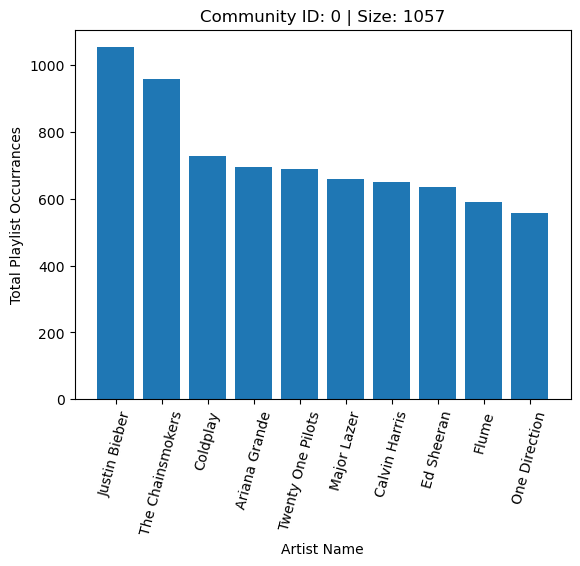

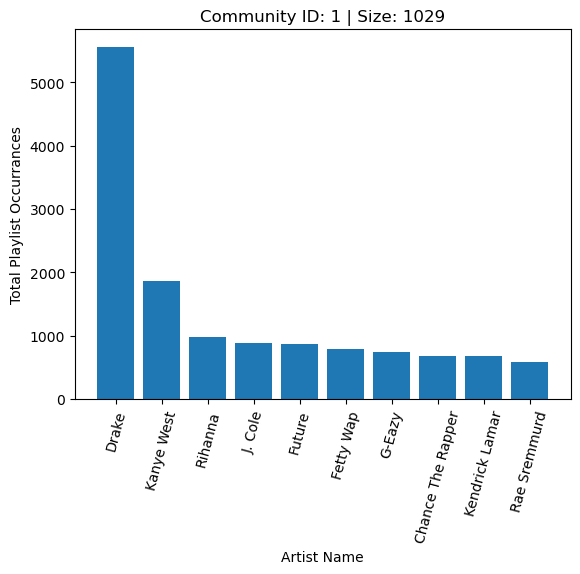

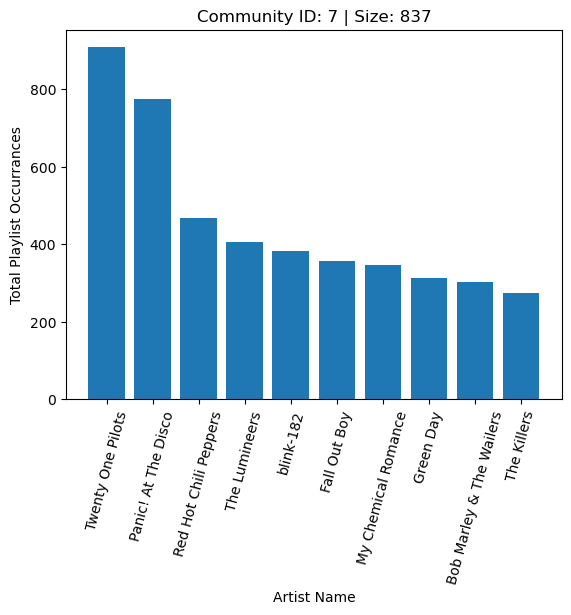

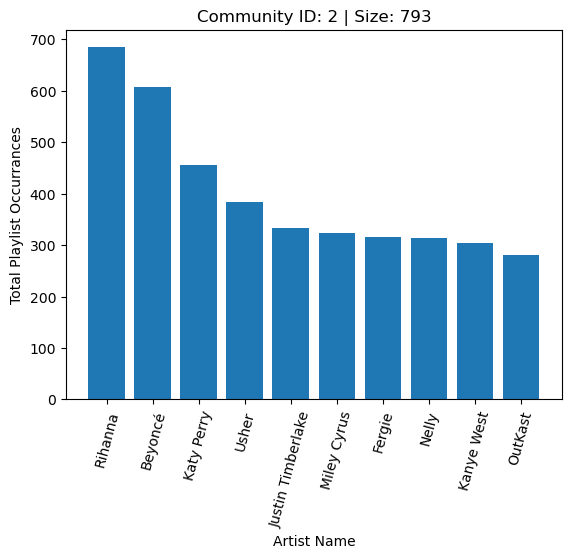

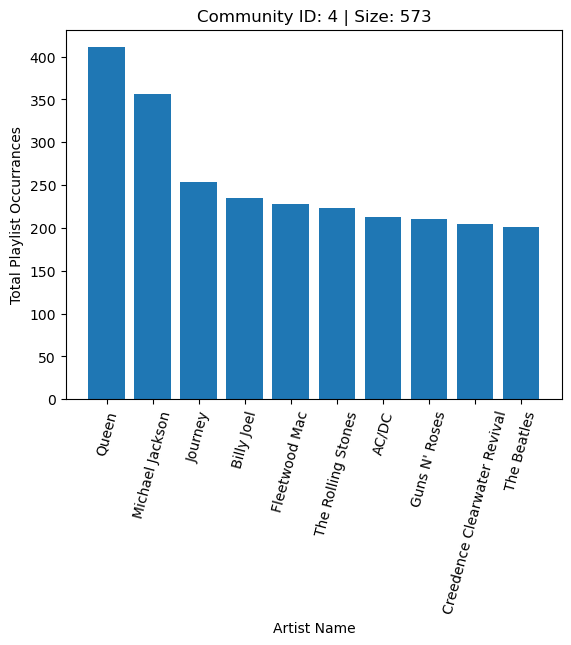

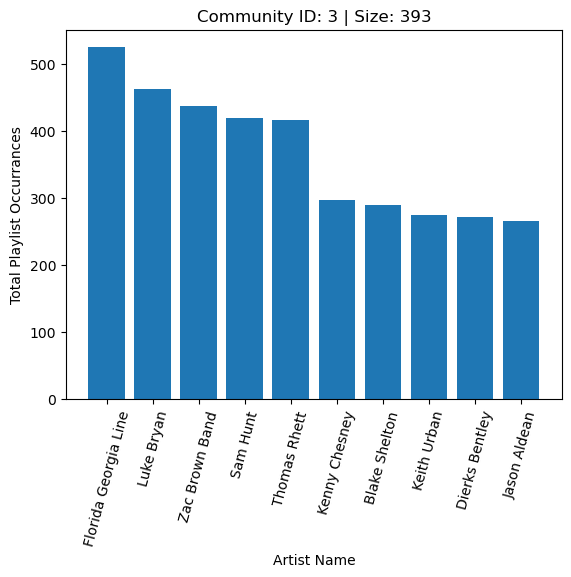

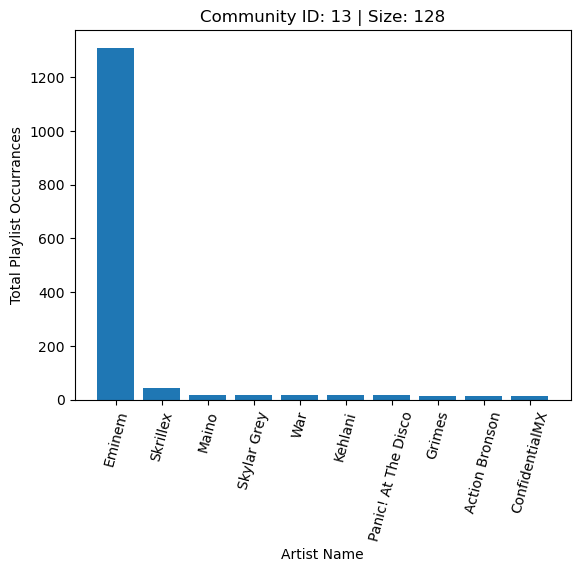

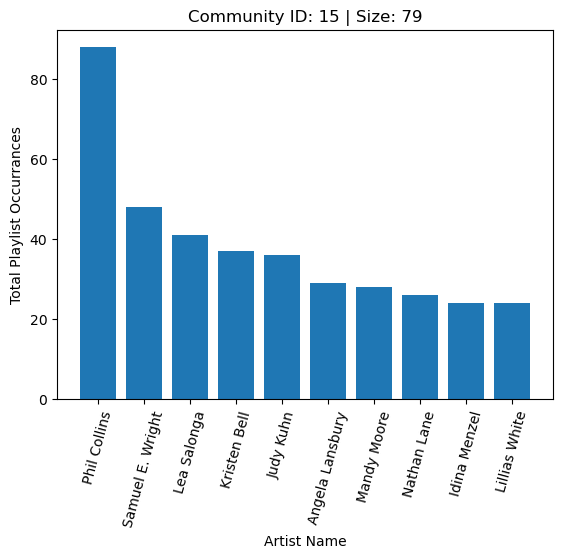

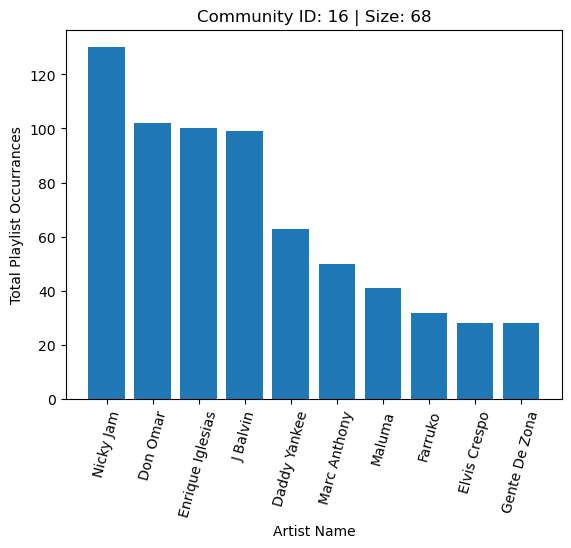

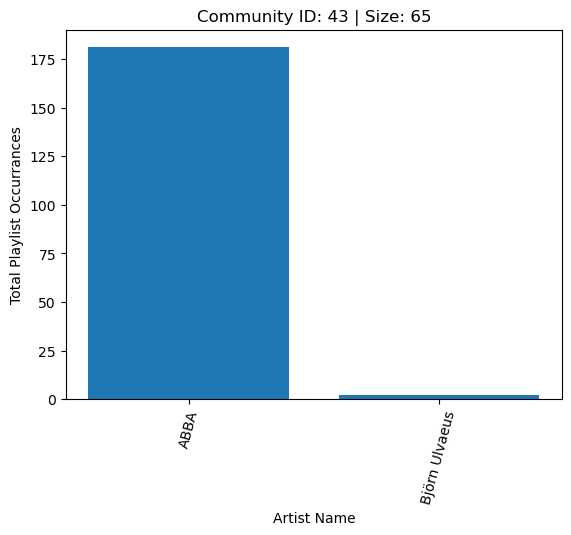

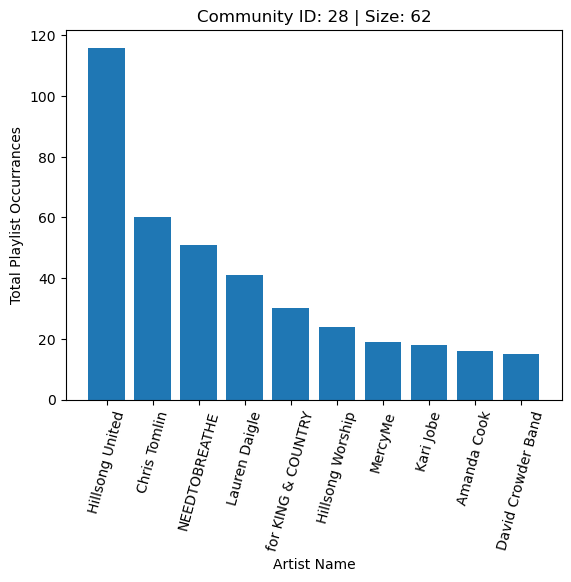

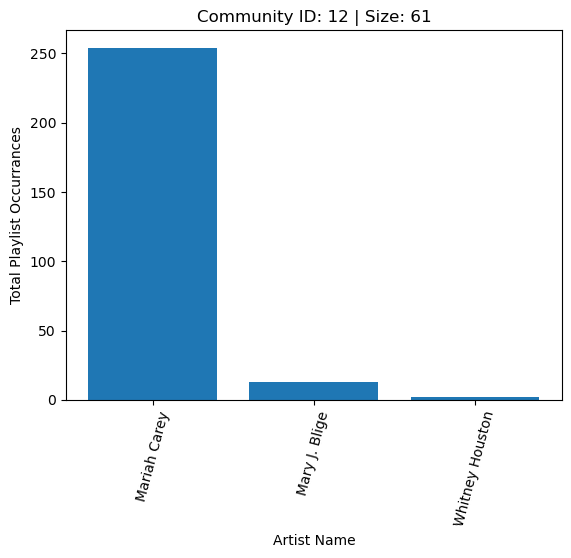

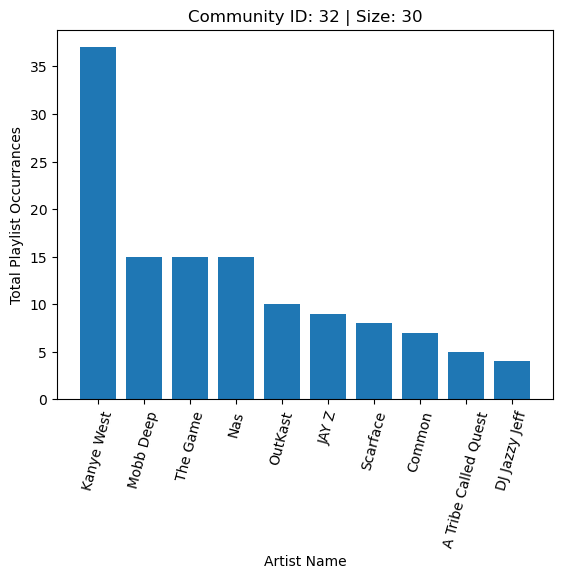

In [112]:
# Top three artist per playlist
for i in number_of_communities:
    top_5_artists = df.query(f'Community_ID == {i}').groupby("Artist")[['Number_of_Playlists']].agg('sum').sort_values("Number_of_Playlists", ascending=False).head(10)
    plt.bar(
        x=top_5_artists.index,
        height='Number_of_Playlists',
        data=top_5_artists
    )
    plt.xlabel("Artist Name")
    plt.ylabel("Total Playlist Occurrances")
    plt.xticks(rotation=75)

    plt.title(f"Community ID: {i} | Size: {len(df.query(f"Community_ID == {i}"))}")
    plt.show()

In [ ]:
""